In [1]:
%autoreload 2

In [2]:
from ast import literal_eval
from collections import Counter
import json
import os
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from tqdm.notebook import tqdm

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *
from src import latest_model_paths

2024-09-19 18:52:15 - ast_utils - DEBUG    - Using cache folder: /Users/guydavidson/tmp/game_generation_cache


In [3]:
SUBPLOTS_ADJUST_PARAMS = dict(top=0.925)
DEFAULT_IGNORE_METRICS = ['Timestamp']


FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = './figures'


def save_plot(save_path, bbox_inches='tight', should_print=False):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        save_path = os.path.abspath(save_path)
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')


# Load data and model

In [4]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]

2024-09-19 18:52:24 - ast_utils - INFO     - Loading from cache file: /Users/guydavidson/tmp/game_generation_cache/interactive-beta-cache.pkl.gz
2024-09-19 18:52:24 - ast_utils - INFO     - Finished loading cache file: /Users/guydavidson/tmp/game_generation_cache/interactive-beta-cache.pkl.gz


['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_prop,variables_used_all,variables_used_prop,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,game-0,medium-objects-room-v1,game-0,1,1,1.0,1,1.0,...,0.969177,0.979573,0.965285,0.976289,0.977376,0.980148,0.915272,0.960175,0.999188,1.000000
1,1,interactive-beta.pddl,game-2,many-objects-room-v1,game-2,1,1,1.0,1,1.0,...,0.974875,0.978991,0.961082,0.972691,0.971810,0.980943,0.895362,0.910697,0.963311,0.973001
2,2,interactive-beta.pddl,game-3,many-objects-room-v1,game-3,1,1,1.0,1,1.0,...,0.954233,0.972808,0.000000,0.000000,0.000000,0.000000,0.841097,0.898279,0.946597,0.955042
3,3,interactive-beta.pddl,game-5,few-objects-room-v1,game-5,1,1,1.0,1,1.0,...,0.986178,0.982877,0.000000,0.000000,0.000000,0.000000,0.915272,0.960175,0.999188,1.000000
4,4,interactive-beta.pddl,game-6,medium-objects-room-v1,game-6,1,1,1.0,1,1.0,...,0.984002,0.979782,0.000000,0.000000,0.000000,0.000000,0.964905,0.971973,0.972563,0.962818


In [5]:
REAL_GAME_INDICES_TO_INCLUDE = [
    0, 4, 6, 7, 11,
    14, 17, 23, 26, 28,
    31, 32, 35, 37, 40,
    41, 42, 45, 49, 51,
    52, 55, 58, 59, 64,
    74, 88, 90, 94, 96,
]

model_key = 'max_exemplar_preferences_by_bcs_with_expected_values'
model_spec = latest_model_paths.MAP_ELITES_MODELS[model_key]
model = typing.cast(MAPElitesSampler, model_spec.load())

key_to_real_game_index = defaultdict(list)
key_to_included_real_game_index = {}
real_game_index_to_key = {}
real_game_fitness_scores = []
ALL_REAL_GAME_KEYS = []
for i, ast in enumerate(game_asts):
    fitness_score, features = model._score_proposal(ast, return_features=True)  # type: ignore
    real_game_fitness_scores.append(fitness_score)
    key = model._features_to_key(ast, features)
    key_to_real_game_index[key].append(i)
    real_game_index_to_key[i] = key
    ALL_REAL_GAME_KEYS.append(key)
    if i in REAL_GAME_INDICES_TO_INCLUDE:
        key_to_included_real_game_index[key] = i


2024-09-19 18:52:27 - compile_predicate_statistics_full_database - INFO     - Loading data from files with query timeout 15
2024-09-19 18:52:47 - compile_predicate_statistics_full_database - INFO     - Creating DuckDB table...
2024-09-19 18:52:48 - compile_predicate_statistics_full_database - INFO     - Creating data table indices...
2024-09-19 18:53:09 - compile_predicate_statistics_full_database - INFO     - Loaded data, found 843825 rows


In [6]:
HELD_OUT_REAL_GAME_INDICES = [
    0, 4, 10, 12, 18, 
    22, 26, 31, 40, 42, 
    44, 47, 62, 64, 73, 
    75, 81, 83, 90, 94
]

held_out_model_key = 'held_out_games'
held_out_model_spec = latest_model_paths.MAP_ELITES_MODELS[held_out_model_key]
held_out_model = typing.cast(MAPElitesSampler, held_out_model_spec.load())

## Compute human game fitness scores under the held out model

In [7]:
held_out_model_real_game_fitness_scores = [
    held_out_model._score_proposal(ast, return_features=False) 
    for ast in game_asts
]

In [8]:
train_fitness_scores, test_fitness_scores = [], []  
for i, ast in enumerate(game_asts):
    if i in HELD_OUT_REAL_GAME_INDICES:
        test_fitness_scores.append(held_out_model_real_game_fitness_scores[i])
    else:
        train_fitness_scores.append(held_out_model_real_game_fitness_scores[i])

print(np.mean(train_fitness_scores), np.std(train_fitness_scores), np.mean(test_fitness_scores), np.std(test_fitness_scores))
print(stats.ttest_ind(train_fitness_scores, test_fitness_scores, equal_var=False))

36.57812113639636 0.7089622959956696 36.55127811431885 0.7946382024989042
TtestResult(statistic=0.13461647173705535, pvalue=0.8939158196264483, df=26.940227023507536)


## Compute held out model sample fitness scores under the full fitness function

In [9]:
full_fitness_function_held_out_sample_scores = {}
    
for key in tqdm(held_out_model.population):
    full_fitness_function_held_out_sample_scores[key] = model._score_proposal(held_out_model.population[key], return_features=False)  # type: ignore


100%|██████████| 4000/4000 [01:43<00:00, 38.49it/s]


In [10]:
full_model_fitness_scores = []
held_out_model_fitness_scores = []

for key in model.population:
    if key[0] == 1:  # type: ignore
        full_model_fitness_scores.append(model.fitness_values[key])
        held_out_model_fitness_scores.append(full_fitness_function_held_out_sample_scores[key])

    
full_model_fitness_scores = np.array(full_model_fitness_scores)
held_out_model_fitness_scores = np.array(held_out_model_fitness_scores)



In [11]:
print(np.mean(full_model_fitness_scores), np.std(full_model_fitness_scores), np.mean(held_out_model_fitness_scores), np.std(held_out_model_fitness_scores))
print(stats.ttest_rel(full_model_fitness_scores, held_out_model_fitness_scores))

36.259096817970274 0.6901896779926944 36.43743419456482 0.6579561541847518
TtestResult(statistic=-18.50370226655235, pvalue=1.1005792590602211e-70, df=1999)


/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_52835/1609969160.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Full Model', 'Model with held-out data'])


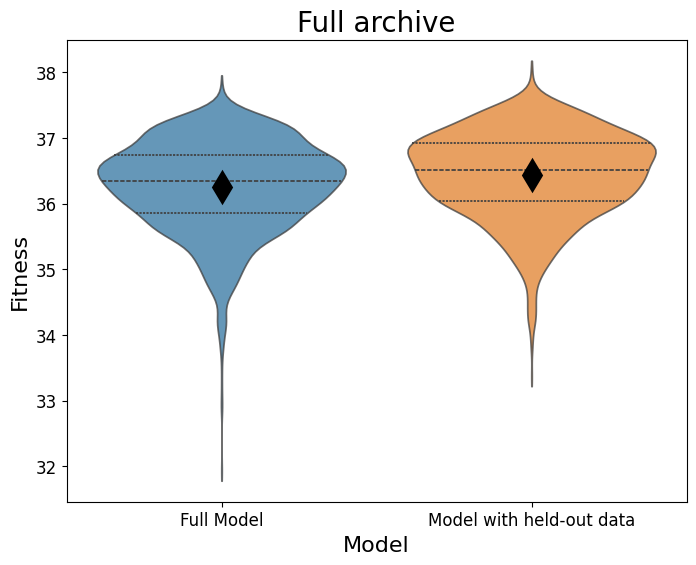

In [12]:
plt.figure(figsize=(8, 6))

sns.violinplot(data=[full_model_fitness_scores, held_out_model_fitness_scores], palette='tab10', inner='quart', alpha=0.75, cut=1)
sns.pointplot(data=[full_model_fitness_scores, held_out_model_fitness_scores], errorbar=('ci', 95), linestyle='none', color='black', markers='d', markersize=15)

plt.title('Full archive', fontsize=20)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Fitness', fontsize=16)

ax = plt.gca()
ax.set_xticklabels(['Full Model', 'Model with held-out data'])
ax.tick_params(axis='both', which='major', labelsize=12)



save_plot('held_out_data_fitness_violinplot.png')
plt.show()

# What about specifically the cells with held-out games?

In [13]:
held_out_game_fitness_scores = []
held_out_cell_full_model_fitness_scores = []
held_out_cell_held_out_model_fitness_scores = []


for held_out_index in HELD_OUT_REAL_GAME_INDICES:
    key = real_game_index_to_key[held_out_index]
    held_out_game_fitness_scores.append(real_game_fitness_scores[held_out_index])
    held_out_cell_full_model_fitness_scores.append(model.fitness_values[key])
    held_out_cell_held_out_model_fitness_scores.append(full_fitness_function_held_out_sample_scores[key])

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_52835/2453629244.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Full Model', 'Model with held-out data', 'Participant games'])


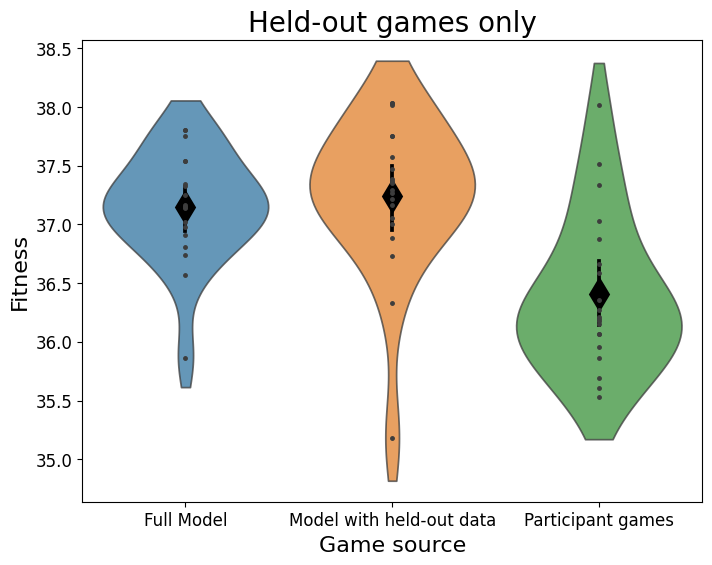

In [14]:
plt.figure(figsize=(8, 6))

sns.violinplot(data=[held_out_cell_full_model_fitness_scores, held_out_cell_held_out_model_fitness_scores, held_out_game_fitness_scores], palette='tab10', inner='point', alpha=0.75, cut=1)
sns.pointplot(data=[held_out_cell_full_model_fitness_scores, held_out_cell_held_out_model_fitness_scores, held_out_game_fitness_scores], errorbar=('ci', 95), linestyle='none', color='black', markers='d', markersize=15)

plt.title('Held-out games only', fontsize=20)
plt.xlabel('Game source', fontsize=16)
plt.ylabel('Fitness', fontsize=16)

ax = plt.gca()
ax.set_xticklabels(['Full Model', 'Model with held-out data', 'Participant games'])
ax.tick_params(axis='both', which='major', labelsize=12)

save_plot('held_out_data_held_out_cell_fitness_violinplot.png')
plt.show()